In [1]:
import numpy as np
import keras
from keras.applications.imagenet_utils import decode_predictions
import skimage.io 
import skimage.segmentation
import copy
import sklearn
import sklearn.metrics
from sklearn.linear_model import LinearRegression
import warnings
import tensorflow as tf
print('Notebook running: keras ', keras.__version__)
np.random.seed(222)
warnings.filterwarnings('ignore') 
inceptionV3_model = tf.keras.applications.InceptionV3(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)
 #Load pretrained model

2022-02-24 23:27:15.026978: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-24 23:27:15.026996: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Notebook running: keras  2.8.0


2022-02-24 23:27:16.544241: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-02-24 23:27:16.544258: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-24 23:27:16.544271: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (IT081869): /proc/driver/nvidia/version does not exist
2022-02-24 23:27:16.544425: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


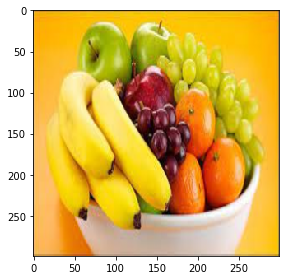

In [2]:
Xi = skimage.io.imread("fruit.jpeg")[:,:,:3]
Xi = skimage.transform.resize(Xi, (299,299)) 
Xi = (Xi - 0.5)*2 #Inception pre-processing
skimage.io.imshow(Xi/2+0.5) # Show image before inception preprocessing

In [3]:
np.random.seed(222)
preds = inceptionV3_model.predict(Xi[np.newaxis,:,:,:])
decode_predictions(preds)[0] #Top 5 classes

[('n07753592', 'banana', 0.4394249),
 ('n07742313', 'Granny_Smith', 0.24754477),
 ('n03482405', 'hamper', 0.19494247),
 ('n07753275', 'pineapple', 0.018014882),
 ('n04204238', 'shopping_basket', 0.01728689)]

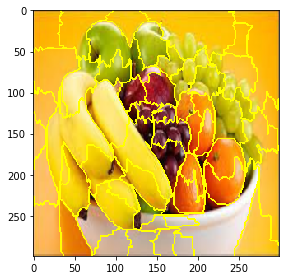

In [4]:
top_pred_classes = preds[0].argsort()[-5:][::-1]
superpixels = skimage.segmentation.quickshift(Xi, kernel_size=4,max_dist=200, ratio=0.2)
num_superpixels = np.unique(superpixels).shape[0]
skimage.io.imshow(skimage.segmentation.mark_boundaries(Xi/2+0.5, superpixels))

In [5]:
def perturb_image(img,perturbation,segments):
  active_pixels = np.where(perturbation == 1)[0]
  mask = np.zeros(segments.shape)
  for active in active_pixels:
      mask[segments == active] = 1 
  perturbed_image = copy.deepcopy(img)
  perturbed_image = perturbed_image*mask[:,:,np.newaxis]
  return perturbed_image
num_perturb = 150
perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))

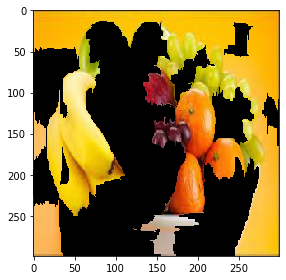

In [6]:
skimage.io.imshow(perturb_image(Xi/2+0.5,perturbations[0],superpixels))

In [7]:
predictions = []
from tqdm import tqdm
for pert in tqdm(perturbations):
  perturbed_img = perturb_image(Xi,pert,superpixels)
  pred = inceptionV3_model.predict(perturbed_img[np.newaxis,:,:,:])
  predictions.append(pred)

predictions = np.array(predictions)
predictions.shape

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:12<00:00, 11.74it/s]


(150, 1, 1000)

In [8]:
original_image = np.ones(num_superpixels)[np.newaxis,:] #Perturbation with all superpixels enabled 
distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='cosine').ravel()
distances.shape

(150,)

In [9]:
kernel_width = 0.25
weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) #Kernel function
weights.shape

(150,)

In [10]:
class_to_explain = top_pred_classes[0]
simpler_model = LinearRegression()
simpler_model.fit(X=perturbations, y=predictions[:,:,class_to_explain], sample_weight=weights)
coeff = simpler_model.coef_[0]
coeff

array([ 0.03252585, -0.01457187, -0.01012692, -0.00018618, -0.0099195 ,
       -0.034722  , -0.01145623, -0.01134191,  0.04451345, -0.01237483,
        0.02013502, -0.0125933 , -0.02628889, -0.01317142,  0.03067736,
       -0.01121596,  0.00177313, -0.02136073, -0.00746298,  0.00879668,
       -0.02318773, -0.0321146 ,  0.001907  ,  0.09863314,  0.01872672,
       -0.03646904,  0.01518036, -0.02568854, -0.0102605 ,  0.02287282,
       -0.00065049,  0.06204451,  0.03430181,  0.04792623,  0.02793648,
        0.08454504,  0.01740004,  0.00434667,  0.00145415,  0.0473972 ,
        0.00661661,  0.06842746,  0.07417103, -0.00735145,  0.00508801,
       -0.00852418,  0.05009381, -0.06974273,  0.00724953,  0.0257559 ,
       -0.04350651,  0.00915255, -0.02438014,  0.02972847, -0.01559737,
       -0.00820685, -0.0099846 ,  0.01246986, -0.02198592])

In [11]:
num_top_features = 4
top_features = np.argsort(coeff)[-num_top_features:] 
top_features

array([41, 42, 35, 23])

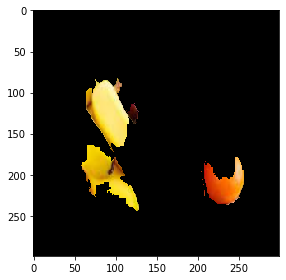

In [12]:
mask = np.zeros(num_superpixels) 
mask[top_features]= True #Activate top superpixels
skimage.io.imshow(perturb_image(Xi/2+0.5,mask,superpixels) )